# PLAN

- [X] Acquisition
    - [X] Select what list of repos to scrape.
        
        -We have selected a compounded group of repositories from the trending repositories list on github in addition to algorithmically scraped repositories that process through the search pages on Github for those that have been 'starred' the most (i.e. we are selecting generally popular repositories)
    - [X] Get requests from the site.
        
        -This is done utilizing BeautifulSoup and detailed by step in a function called get_all_readme_files_and_languages as found in an acquire.py script
    - [X] Save responses to csv.
        
        -URL extensions are saved to local csv, a list of dictionaries that give us the title, readme, and primary coding language for each repository are saved into a local .json file.  Subsequent queries after initial read from these local files to avoid hitting Github excessively with requests, which wound up being problemating after too many hits.
- [X] Preparation
    - [X] Prepare the data for analysis.
        
        -We will clean our readme data by removing special characters, numbers, and foreign languages and making the text uniform for comparison.  We will examine lemmatized and stemmed words.  We will remove common stopwords as well as the explicit languages so we are not handing ourselves the answer from what the readme might be literally saying, or subsequentally misinterpreting what the readme is saying if it references a language that they did not personally utilize.  For each repository the "Primary Language" is selected so that we are more able to apply a classification model to our dataset.  Scraped from the HTML in our acquire file, the first language class found is used in the script, as they are ordered on Github by percentage used.  If the first instance is listed as a Jupyter Notebook, the second instance is taken due to this being a file format and not a language in the pure sense.
       
       -To simplify classification, we will examine the top languages utilized by number of repositories.
- [ ] Exploration
    - [ ] Answer the following prompts:
        - [ ] What are the most common words in READMEs?
        - [ ] What does the distribution of IDFs look like for the most common words?
        - [ ] Does the length of the README vary by language?
        - [ ] Do different languages use a different number of unique words?
- [ ] Modeling
    - [ ] Transform the data for machine learning; use language to predict.
    - [ ] Fit several models using different text repressentations.
    - [ ] Build a function that will take in the text of a README file, and makes a prediction of language.
- [ ] Delivery
    - [ ] Github repo
        - [x] This notebook.
        - [ ] Documentation within the notebook.
        - [ ] README file in the repo.
        - [ ] Python scripts if applicable.
    - [ ] Google Slides
        - [ ] 1-2 slides only summarizing analysis.
        - [ ] Visualizations are labeled.
        - [ ] Geared for the general audience.
        - [ ] Share link @ readme file and/or classroom.

# ENVIRONMENT

In [1]:
# import acquire script: 
from acquire import get_all_readme_files_and_languages
# import prepare scripts: 
from prepare import prepare_repo_html_data
from prepare import basic_clean
# utility imports and pandas for data analysis:
import re
import unicodedata
import numpy as np
import pandas as pd
# import nltk for language analysis: 
import nltk
#matplotlib and seaborn for plotting: 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# scipy.stats for analysis
from scipy.stats import ttest_ind as ttest
from wordcloud import WordCloud

# sentiment analysis importation
from afinn import Afinn

# ACQUIRE

### Collect the languages and readme files listed for each repo

In [2]:
# initialize our lists of potential excluded and extended stopwords
extra_words = []
exclude_words = []

In [3]:
# gather our repositories through our acquire function:
repositories = get_all_readme_files_and_languages()

# PREPARE

In [4]:
# create a transformed dataset dictionary, as well as a dataframe for exploration
transformed_data, df = prepare_repo_html_data(repositories, extra_words, exclude_words)

In [5]:
# check key values in transformed dataset
transformed_data[0].keys()

dict_keys(['title', 'language', 'original', 'lemmatized', 'stemmed'])

In [6]:
# check head of dataframe
df.head(3)

,language,lemmatized,original,stemmed,title
0,C++,welcome repository contains source code window...,Welcome! This repository contains the source c...,welcome repository contains source code window...,microsoft/Terminal
1,HTML,python python python c c python python java g...,Python - 100天从新手到大师\n\n作者：骆昊\n\nPython应用领域和就业形...,python python python c c python python java g...,jackfrued/Python-100-Days
2,Ruby,css chat truly monstrous async web chat using ...,CSS-Only Chat\nA truly monstrous async web cha...,css chat truly monstrous async web chat using ...,kkuchta/css-only-chat


### Create a list of languages that are "cleaned" (lower case with no symbols) so that we can remove them from the readme texts:

In [7]:
# iterate through our dataframe to acquire unique languages, and apply transformation to them
for i in range(df.shape[0]):
    next_lang = transformed_data[i]['language'].lower()
    next_lang = re.sub(r'[^\w\s]', ' ', next_lang).strip()
    if next_lang not in extra_words:
        extra_words.append(next_lang)
# Remove languages from the readme files with another call to prepare_repo_html:
transformed_data, df = prepare_repo_html_data(repositories, extra_words, exclude_words)

In [8]:
extra_words = extra_words + ['http'] #http is not in our languages but pops up a lot
extra_words

['c',
 'html',
 'ruby',
 'vue',
 'java',
 'dart',
 'python',
 'css',
 'rust',
 'shell',
 'javascript',
 'go',
 'typescript',
 'scala',
 'kotlin',
 'smarty',
 'emacs lisp',
 'lua',
 'objective c',
 'tex',
 'common lisp',
 'clojure',
 'jupyter notebook',
 'r',
 'powershell',
 'perl',
 'php',
 'http']

In [9]:
transformed_data, df = prepare_repo_html_data(repositories, extra_words, exclude_words)

### Note that all of the words that reference languages have been removed from the "stemmed" and "lemmatized" versions:

In [10]:
flag = False
for word in df.stemmed[1].split(' ') or word in df.lemmatized[1].split(' '):
    if word in extra_words and word != 'c':
        print(word)
        print()
        flag = True
if flag:
    print('Need to clean more...')
else:
    print('All clean!')

All clean!


In [11]:
# peek at new dataframe:
df.head() # dataframe

,language,lemmatized,original,stemmed,title
0,C++,welcome repository contains source code window...,Welcome! This repository contains the source c...,welcome repository contains source code window...,microsoft/Terminal
1,HTML,devops matlab lisp make english working lang...,Python - 100天从新手到大师\n\n作者：骆昊\n\nPython应用领域和就业形...,devops matlab lisp make english working lang...,jackfrued/Python-100-Days
2,Ruby,chat truly monstrous async web chat using js w...,CSS-Only Chat\nA truly monstrous async web cha...,chat truly monstrous async web chat using js w...,kkuchta/css-only-chat
3,Ruby,overview powertoys set utilities power users t...,Overview\nPowerToys is a set of utilities for ...,overview powertoys set utilities power users t...,microsoft/PowerToys
4,Vue,beautifully simple click copy effects https cs...,Beautifully simple click-to-copy CSS effects\n...,beautifully simple click copy effects https cs...,jolaleye/cssfx


### And a clean list of dictionaries:

In [12]:
transformed_data[0] 

{'title': 'microsoft/Terminal',
 'language': 'C++',
 'original': 'Welcome! This repository contains the source code for:\n\nWindows Terminal\nThe Windows console host (conhost.exe)\nComponents shared between the two projects\nColorTool\nSample projects that show how to consume the Windows Console APIs\n\nBuild Status\n\n\n\nProject\nBuild Status\n\n\n\n\nTerminal\n\n\n\nColorTool\n\n\n\n\nTerminal & Console Overview\nPlease take a few minutes to review the overview below before diving into the code:\nWindows Terminal\nWindows Terminal is a new, modern, feature-rich, productive terminal application for command-line users. It includes many of the features most frequently requested by the Windows command-line community including support for tabs, rich text, globalization, configurability, theming & styling, and more.\nThe Terminal will also need to meet our goals and measures to ensure it remains fast, and efficient, and doesn\'t consume vast amounts of memory or power.\nThe Windows conso

# EXPLORE

# Insert some exposition and elaboration here, direction in steps, etc.

In [13]:
# Get the percent of each language that is in the data set.
languages = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
languages.columns = ['n', 'percent']
languages

,n,percent
JavaScript,50,0.273224
Python,23,0.125683
Java,18,0.098361
C++,14,0.076503
Go,11,0.060109
Scala,7,0.038251
HTML,7,0.038251
Ruby,6,0.032787
Objective-C,6,0.032787
TypeScript,5,0.027322


In [14]:
df.head(3)

,language,lemmatized,original,stemmed,title
0,C++,welcome repository contains source code window...,Welcome! This repository contains the source c...,welcome repository contains source code window...,microsoft/Terminal
1,HTML,devops matlab lisp make english working lang...,Python - 100天从新手到大师\n\n作者：骆昊\n\nPython应用领域和就业形...,devops matlab lisp make english working lang...,jackfrued/Python-100-Days
2,Ruby,chat truly monstrous async web chat using js w...,CSS-Only Chat\nA truly monstrous async web cha...,chat truly monstrous async web chat using js w...,kkuchta/css-only-chat


In [15]:
df.stemmed[:5]

0    welcome repository contains source code window...
1     devops matlab lisp  make english working lang...
2    chat truly monstrous async web chat using js w...
3    overview powertoys set utilities power users t...
4    beautifully simple click copy effects https cs...
Name: stemmed, dtype: object

In [16]:
# Get the word count and frequency for all of the readmes:
all_words = ' '.join(df.stemmed)
word_freq_for_all = pd.Series(all_words.split()).value_counts()

In [17]:
# Create a list of word frequencies per language: 
list_of_lang_word_lists = []
for repo_num in range(len(transformed_data)):
    top_twenty = pd.Series(transformed_data[repo_num]['stemmed'].split()).value_counts().head(20)
    word_freq_per_language ={
        'language': transformed_data[repo_num]['language'],
        'lang_word_list': top_twenty
        }
    list_of_lang_word_lists.append(word_freq_per_language)
word_freq_per_language

{'language': 'Python', 'lang_word_list': requests         15
 user              3
 u                 3
 bug               3
 support           3
 connection        3
 automatic         3
 feature           3
 documentation     2
 familiar          2
 install           2
 pipenv            2
 contributor       2
 downloads         2
 send              2
 open              2
 issues            2
 start             2
 need              2
 code              2
 dtype: int64}

### We will take a look at the most common languages by value count in our dataframe and classify from there

In [18]:
df.language.value_counts()

JavaScript          50
Python              23
Java                18
C++                 14
Go                  11
Scala                7
HTML                 7
Ruby                 6
Objective-C          6
TypeScript           5
Rust                 4
Kotlin               4
PHP                  3
Dart                 3
Smarty               2
Jupyter Notebook     2
C                    2
C#                   2
CSS                  2
Vue                  2
Shell                2
TeX                  1
Lua                  1
Clojure              1
Common Lisp          1
R                    1
Emacs Lisp           1
Perl                 1
PowerShell           1
Name: language, dtype: int64

## We will take a look at the words of the top 8 languages listed by value counts, excluding HTML (everything with 6 or more instances)

In [19]:
# Create a list of the first nine languages by value count.
top_languages = list(df.language.value_counts()[0:9].index)
top_languages

['JavaScript',
 'Python',
 'Java',
 'C++',
 'Go',
 'Scala',
 'HTML',
 'Ruby',
 'Objective-C']

In [20]:
# Remove HTML.
top_languages.remove('HTML')

In [21]:
# Peek at our top language list.
top_languages

['JavaScript', 'Python', 'Java', 'C++', 'Go', 'Scala', 'Ruby', 'Objective-C']

In [22]:
# Reduce dataframe to top 8 languages.
df = df[df.language.isin(top_languages)]

In [23]:
# See how many samples we are left with:
df.shape

(135, 5)

In [24]:
# Ensure that the trimming worked:
df.language.value_counts()

JavaScript     50
Python         23
Java           18
C++            14
Go             11
Scala           7
Objective-C     6
Ruby            6
Name: language, dtype: int64

## We have 135 samples and 8 different languages for classification! A great start.  Let's get our hands dirty.

In [25]:
# obtain word count and frequency for entire data set:
all_words = ' '.join(df.stemmed)
word_freq_for_all = pd.Series(all_words.split()).value_counts()

In [26]:
# make words based on joined strings where dataframe criteria meets stated conditions:
javascript_words = ' '.join(df[df.language == 'JavaScript'].stemmed)
cplusplus_words = ' '.join(df[df.language == 'C++'].stemmed)
python_words = ' '.join(df[df.language == 'Python'].stemmed)
java_words = ' '.join(df[df.language == 'Java'].stemmed)
go_words = ' '.join(df[df.language == 'Go'].stemmed)
ruby_words = ' '.join(df[df.language == 'Ruby'].stemmed)
scala_words = ' '.join(df[df.language == 'Scala'].stemmed)
obj_c_words = ' '.join(df[df.language == 'Objective-C'].stemmed)

# Matt: I wonder if we need to calculate and use augmented frequency...

# Augmented Frequency: the frequency of each word divided by the maximum frequency. This can help prevent bias towards larger documents.

In [27]:
# calculate word frequencies for each large string of language-use words
javascript_freq = pd.Series(javascript_words.split()).value_counts()
cplusplus_freq = pd.Series(cplusplus_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
java_freq = pd.Series(java_words.split()).value_counts()
go_freq = pd.Series(go_words.split()).value_counts()
ruby_freq = pd.Series(ruby_words.split()).value_counts()
scala_freq = pd.Series(scala_words.split()).value_counts()
obj_c_freq = pd.Series(obj_c_words.split()).value_counts()

In [28]:
# get word counts together and concatinate them into a single dataframe:

word_counts = (pd.concat([word_freq_for_all, javascript_freq, cplusplus_freq, python_freq, java_freq, go_freq, ruby_freq, scala_freq, obj_c_freq], axis=1, sort=True)
                .set_axis(['all', 'javascript', 'cplusplus', 'python', 'java', 'go', 'ruby', 'scala', 'obj_c'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

#peek at top head of word counts and tail of word counts
word_counts.head().append(word_counts.tail())

,all,javascript,cplusplus,python,java,go,ruby,scala,obj_c
a,9,5,0,4,0,0,0,0,0
aa,2,1,0,0,0,0,1,0,0
aaaaaadbzru,1,0,0,0,0,0,0,1,0
aabbceg,1,1,0,0,0,0,0,0,0
aac,1,0,0,0,0,1,0,0,0
zurich,1,1,0,0,0,0,0,0,0
zxcvbn,1,1,0,0,0,0,0,0,0
zxf,1,0,0,1,0,0,0,0,0
zynga,1,0,0,1,0,0,0,0,0
zyszys,2,2,0,0,0,0,0,0,0


## Let's investigate the most common words across our data set:

In [29]:
# most common words (stemmed) across data set
word_counts.sort_values(by='all', ascending=False).head(10)

,all,javascript,cplusplus,python,java,go,ruby,scala,obj_c
js,1157,1073,13,48,2,7,3,10,1
use,1105,774,22,176,25,53,17,19,19
data,913,346,20,424,14,88,11,9,1
const,826,823,3,0,0,0,0,0,0
library,772,95,27,327,6,272,5,32,8
array,706,690,0,10,0,3,0,2,1
function,698,635,16,20,7,6,0,8,6
using,639,381,26,126,12,74,8,6,6
x,610,425,20,110,22,10,2,15,6
code,546,227,44,133,21,89,12,11,9


### JavaScript, Python, Java, and C++ are the most common languages, so let's look at them.

In [30]:
pd.concat([word_counts.sort_values(by='javascript').tail(3),
           word_counts.sort_values(by='python').tail(3),
           word_counts.sort_values(by='java').tail(3),
          word_counts.sort_values(by='cplusplus').tail(3)])

,all,javascript,cplusplus,python,java,go,ruby,scala,obj_c
use,1105,774,22,176,25,53,17,19,19
const,826,823,3,0,0,0,0,0,0
js,1157,1073,13,48,2,7,3,10,1
library,772,95,27,327,6,272,5,32,8
learning,456,28,16,388,0,22,0,2,0
data,913,346,20,424,14,88,11,9,1
type,260,101,13,46,37,15,2,32,14
rxjava,40,0,1,0,39,0,0,0,0
license,189,65,14,16,41,16,10,23,4
cache,228,77,58,77,1,13,0,2,0


# MATT -- I wasn't sure if you wanted the tail to be 3? Your comment in the next cell indicated this cell was tail(3), but in fact it was tail() which defaults to 5...

In [31]:
# Look at only Javascript and Python
# Look at the word counts in one language when the other does not have any occurences 
# of that word.
jvs_pyt = pd.DataFrame() 
jvs_pyt = pd.concat([word_counts[word_counts.python == 0].sort_values(by='javascript').tail(),
           word_counts[word_counts.javascript == 0].sort_values(by='python').tail()])
jvs_pyt[['all', 'javascript', 'python']]

,all,javascript,python
obj,201,201,0
val,308,269,0
arr,304,304,0
prototype,356,351,0
const,826,823,0
julia,47,0,45
science,56,0,47
weeks,56,0,55
natural,75,0,64
httpie,103,0,103


# MATT -- should we delete this cell?

In [32]:
# compare difference between javascript and python top words with a little more breadth 
# (6 instead of 3)
pd.concat([word_counts[['javascript', 'python']][word_counts.javascript == 0].sort_values(by='python').tail(6),
           word_counts[['javascript', 'python']][word_counts.python == 0].sort_values(by='javascript').tail(6)])

,javascript,python
pip,0,39
julia,0,45
science,0,47
weeks,0,55
natural,0,64
httpie,0,103
vuex,186,0
obj,201,0
val,269,0
arr,304,0


In [33]:
# Is there a significant difference in the average count of each word in javascript 
# and python?

ttest(word_counts.python, word_counts.java)

Ttest_indResult(statistic=25.848613417699283, pvalue=7.4667623023033105e-146)

A t-score of 25.8 means the groups are 25.8 times as different from each other as they are within each other.
- The larger the t statistic, the more difference there is between the groups, the more likely it is that the results are repeatable, i.e. that the difference is significant.

- The smaller the score, the more similarity.

So this shows that the words in the Python and Java readme files are significantly different from each other.

### Let's compare Javascript and Java.

In [34]:
jvs_java = pd.DataFrame() 
jvs_java = pd.concat([word_counts[word_counts.java == 0].sort_values(by='javascript').tail(),
           word_counts[word_counts.javascript == 0].sort_values(by='java').tail()])
jvs_java[['all', 'javascript', 'java']]

,all,javascript,java
arr,304,304,0
prototype,356,351,0
component,474,466,0
array,706,690,0
const,826,823,0
flatmap,17,0,16
reactivex,21,0,21
schedulers,22,0,21
flowable,34,0,34
rxjava,40,0,39


### And now Javascript and C++...

In [35]:
jvs_cpp = pd.DataFrame() 
jvs_cpp = pd.concat([word_counts[word_counts.cplusplus == 0].sort_values(by='javascript').tail(),
           word_counts[word_counts.javascript == 0].sort_values(by='cplusplus').tail()])
jvs_cpp[['all', 'javascript', 'cplusplus']]

,all,javascript,cplusplus
arr,304,304,0
n,406,320,0
b,487,376,0
component,474,466,0
array,706,690,0
pypi,19,0,8
catboost,17,0,13
gpu,36,0,14
cmake,16,0,15
xcode,33,0,20


### And Python and Java...

In [36]:
pyt_java = pd.DataFrame() 
pyt_java = pd.concat([word_counts[word_counts.java == 0].sort_values(by='python').tail(),
           word_counts[word_counts.python == 0].sort_values(by='java').tail()])
pyt_java[['all', 'python', 'java']]

,all,python,java
neural,126,103,0
django,116,104,0
framework,309,113,0
machine,339,290,0
learning,456,388,0
flatmap,17,0,16
schedulers,22,0,21
reactivex,21,0,21
flowable,34,0,34
rxjava,40,0,39


### Python and C++

In [37]:
pyt_cpp = pd.DataFrame() 
pyt_cpp = pd.concat([word_counts[word_counts.cplusplus == 0].sort_values(by='python').tail(),
           word_counts[word_counts.python == 0].sort_values(by='cplusplus').tail()])
pyt_cpp[['all', 'python', 'cplusplus']]

,all,python,cplusplus
n,406,70,0
output,111,80,0
b,487,82,0
httpie,103,103,0
deprecated,172,163,0
generatefunc,20,0,10
toolchain,12,0,11
nightly,18,0,14
xcode,33,0,20
ninja,27,0,24


### Java and C++

In [38]:
java_cpp = pd.DataFrame() 
java_cpp = pd.concat([word_counts[word_counts.cplusplus == 0].sort_values(by='java').tail(),
           word_counts[word_counts.java == 0].sort_values(by='cplusplus').tail()])
java_cpp[['all', 'java', 'cplusplus']]

,all,java,cplusplus
elasticsearch,47,20,0
reactivex,21,21,0
schedulers,22,21,0
operator,84,27,0
flowable,34,34,0
key,300,0,25
framework,309,0,33
tensorflow,75,0,36
electron,85,0,48
swift,99,0,73


### Let's create a bar graph to visualize the proportion of language for each of the 20 most common words.

Text(0.5, 1.0, 'Proportion of language for the 20 most common words')

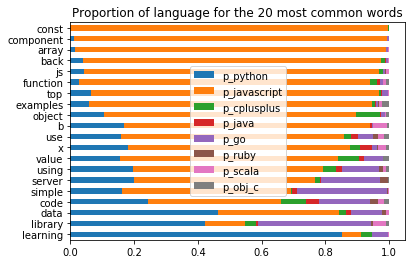

In [39]:
(word_counts
 .assign(p_python = word_counts.python / word_counts['all'],
         p_javascript = word_counts.javascript / word_counts['all'], 
         p_cplusplus = word_counts.cplusplus / word_counts['all'],
         p_java = word_counts.java / word_counts['all'], 
         p_go = word_counts.go / word_counts['all'], 
         p_ruby = word_counts.ruby / word_counts['all'], 
         p_scala = word_counts.scala / word_counts['all'],
         p_obj_c = word_counts.obj_c / word_counts['all'])
 .sort_values(by='all')
 [['p_python', 'p_javascript', 'p_cplusplus', 'p_java', 'p_go', 'p_ruby', 'p_scala', 'p_obj_c']]
 .tail(20)
 .sort_values('p_javascript')
 .plot.barh(stacked=True))

plt.title('Proportion of language for the 20 most common words')

# So the most common words will likely be good predictors of the language. "const" is a very strong predictor of Javascript and "learning" is an almost as strong predictor of Python.

# Let's visualize the words common for each language in word clouds.

### First, all words:

(-0.5, 799.5, 399.5, -0.5)

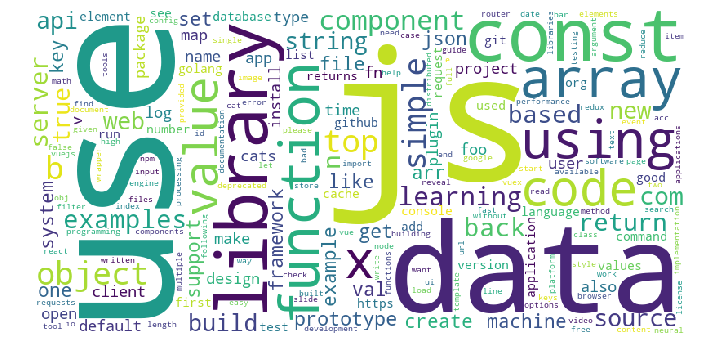

In [40]:
cloud = WordCloud(background_color='white', width=800, height=400)
all_img = cloud.generate_from_frequencies(word_freq_for_all)
plt.figure(figsize=(20, 6))
plt.imshow(all_img)
plt.axis('off')

# Create wordclouds for each language

### Javascript

In [41]:
javascript_freq.head(10)

js           1073
const         823
use           774
array         690
function      635
component     466
top           432
x             425
back          409
object        393
dtype: int64

(-0.5, 799.5, 399.5, -0.5)

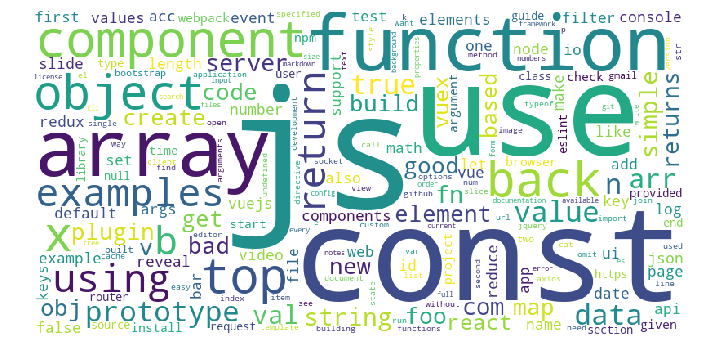

In [42]:
cloud = WordCloud(background_color='white', width=800, height=400)
all_img = cloud.generate_from_frequencies(javascript_freq)
plt.figure(figsize=(20, 6))
plt.imshow(all_img)
plt.axis('off')

### C++

In [43]:
cplusplus_freq.head(10)

build         74
swift         73
cache         58
electron      48
source        46
code          44
object        37
tensorflow    36
windows       36
open          34
dtype: int64

(-0.5, 799.5, 399.5, -0.5)

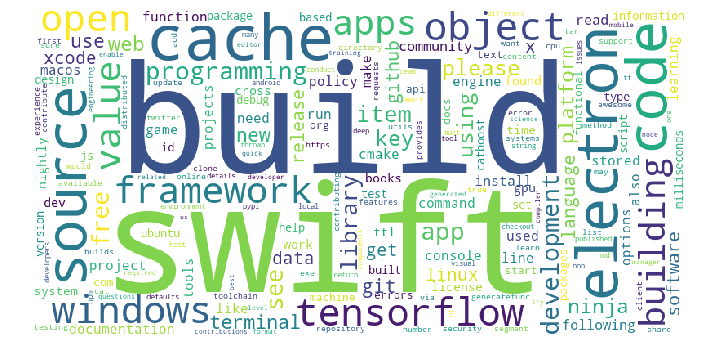

In [44]:
cloud = WordCloud(background_color='white', width=800, height=400)
all_img = cloud.generate_from_frequencies(cplusplus_freq)
plt.figure(figsize=(20, 6))
plt.imshow(all_img)
plt.axis('off')

### Python

In [45]:
python_freq.head(10)

data          424
learning      388
library       327
machine       290
use           176
deprecated    163
system        155
source        153
design        135
command       135
dtype: int64

(-0.5, 799.5, 399.5, -0.5)

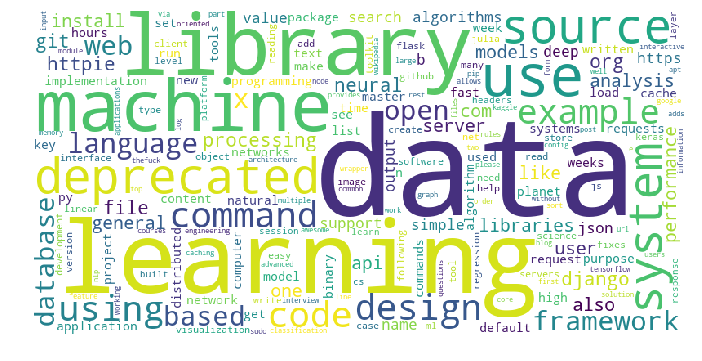

In [46]:
cloud = WordCloud(background_color='white', width=800, height=400)
all_img = cloud.generate_from_frequencies(python_freq)
plt.figure(figsize=(20, 6))
plt.imshow(all_img)
plt.axis('off')

### Java

In [47]:
java_freq.head(10)

license     41
rxjava      39
type        37
flowable    34
single      29
io          28
system      27
operator    27
index       26
source      25
dtype: int64

(-0.5, 799.5, 399.5, -0.5)

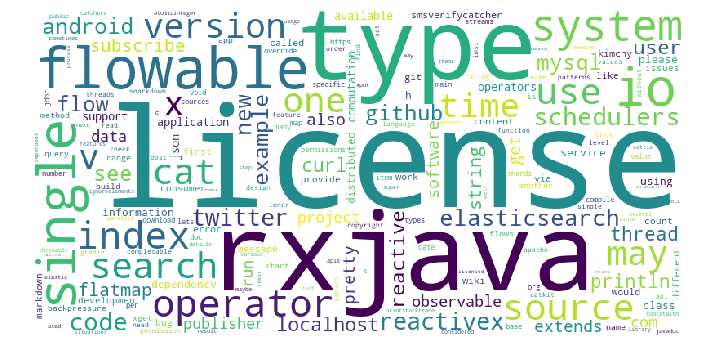

In [48]:
cloud = WordCloud(background_color='white', width=800, height=400)
all_img = cloud.generate_from_frequencies(java_freq)
plt.figure(figsize=(20, 6))
plt.imshow(all_img)
plt.axis('off')

### Go

In [49]:
go_freq.head(10)

library      272
golang       198
package      140
simple       139
api          113
client        93
based         92
code          89
framework     88
data          88
dtype: int64

(-0.5, 799.5, 399.5, -0.5)

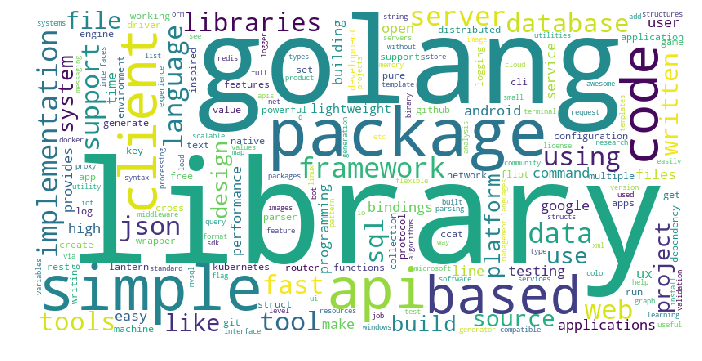

In [50]:
cloud = WordCloud(background_color='white', width=800, height=400)
all_img = cloud.generate_from_frequencies(go_freq)
plt.figure(figsize=(20, 6))
plt.imshow(all_img)
plt.axis('off')

### Ruby

In [51]:
ruby_freq.head(10)

rails      37
cat        19
use        17
catarse    17
nyan       17
run        16
action     14
project    13
button     13
com        13
dtype: int64

(-0.5, 799.5, 399.5, -0.5)

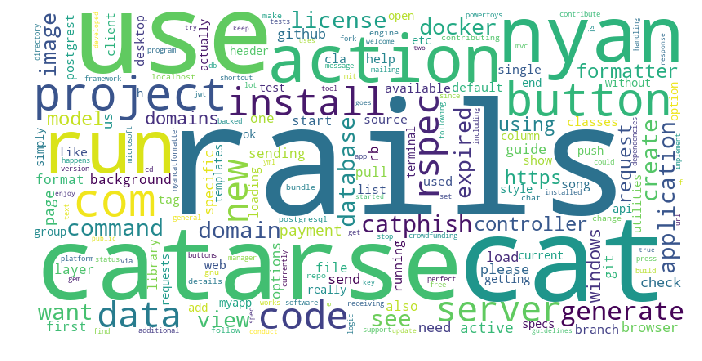

In [52]:
cloud = WordCloud(background_color='white', width=800, height=400)
all_img = cloud.generate_from_frequencies(ruby_freq)
plt.figure(figsize=(20, 6))
plt.imshow(all_img)
plt.axis('off')

### Scala

In [53]:
scala_freq.head(10)

cats          185
typelevel      41
org            36
thrpt          36
string         35
library        32
type           32
version        31
show           27
functional     27
dtype: int64

(-0.5, 799.5, 399.5, -0.5)

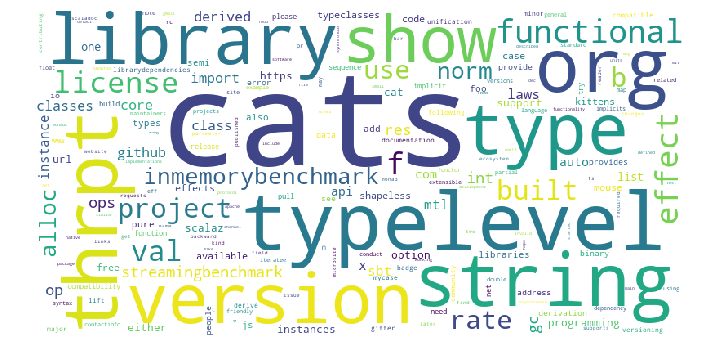

In [54]:
cloud = WordCloud(background_color='white', width=800, height=400)
all_img = cloud.generate_from_frequencies(scala_freq)
plt.figure(figsize=(20, 6))
plt.imshow(all_img)
plt.axis('off')

### Objective-C

In [55]:
obj_c_freq.head(10)

rx                     82
match                  43
string                 40
nsstring               40
show                   28
nsregularexpression    25
replace                22
cats                   20
matches                20
import                 19
dtype: int64

(-0.5, 799.5, 399.5, -0.5)

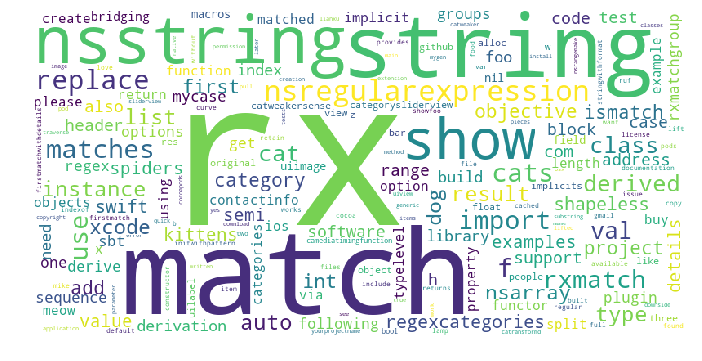

In [56]:
cloud = WordCloud(background_color='white', width=800, height=400)
all_img = cloud.generate_from_frequencies(obj_c_freq)
plt.figure(figsize=(20, 6))
plt.imshow(all_img)
plt.axis('off')

# Let's create a dataframe containing the ten most common words per language with their word counts.

In [57]:
word_freq_for_all.values[:10]

array([1157, 1105,  913,  826,  772,  706,  698,  639,  610,  546])

In [58]:
combined_freq_df = pd.DataFrame()
combined_freq_df['all_w'] = word_freq_for_all.index[:10]
combined_freq_df['all_v'] = word_freq_for_all.values[:10]

combined_freq_df['js_w'] = javascript_freq .index[:10]
combined_freq_df['js_v'] = javascript_freq .values[:10]

combined_freq_df['cpp_w'] = cplusplus_freq.index[:10]
combined_freq_df['cpp_v'] = cplusplus_freq.values[:10]

combined_freq_df['python_w'] = python_freq.index[:10]
combined_freq_df['python_v'] = python_freq.values[:10]

combined_freq_df['java_w'] = java_freq.index[:10]
combined_freq_df['java_v'] = java_freq.values[:10]

combined_freq_df['go_w'] = go_freq.index[:10]
combined_freq_df['go_v'] = go_freq.values[:10]

combined_freq_df['ruby_w'] = ruby_freq.index[:10]
combined_freq_df['ruby_v'] = ruby_freq.values[:10]

combined_freq_df['scala_w'] = scala_freq.index[:10]
combined_freq_df['scala_v'] = scala_freq.values[:10]

combined_freq_df['obj_c_w'] = obj_c_freq.index[:10]
combined_freq_df['obj_c_v'] = obj_c_freq.values[:10]

combined_freq_df

,all_w,all_v,js_w,js_v,cpp_w,cpp_v,python_w,python_v,java_w,java_v,go_w,go_v,ruby_w,ruby_v,scala_w,scala_v,obj_c_w,obj_c_v
0,js,1157,js,1073,build,74,data,424,license,41,library,272,rails,37,cats,185,rx,82
1,use,1105,const,823,swift,73,learning,388,rxjava,39,golang,198,cat,19,typelevel,41,match,43
2,data,913,use,774,cache,58,library,327,type,37,package,140,use,17,org,36,string,40
3,const,826,array,690,electron,48,machine,290,flowable,34,simple,139,catarse,17,thrpt,36,nsstring,40
4,library,772,function,635,source,46,use,176,single,29,api,113,nyan,17,string,35,show,28
5,array,706,component,466,code,44,deprecated,163,io,28,client,93,run,16,library,32,nsregularexpression,25
6,function,698,top,432,object,37,system,155,system,27,based,92,action,14,type,32,replace,22
7,using,639,x,425,tensorflow,36,source,153,operator,27,code,89,project,13,version,31,cats,20
8,x,610,back,409,windows,36,design,135,index,26,framework,88,button,13,show,27,matches,20
9,code,546,object,393,open,34,command,135,source,25,data,88,com,13,functional,27,import,19


## Consider the sentiment score for each language.

In [59]:
afinn = Afinn()

# MATT-- I have no idea why this didn't work. That's why I ran the commands and then manually created the series. But the results are significant.

In [60]:
df.columns

Index(['language', 'lemmatized', 'original', 'stemmed', 'title'], dtype='object')

In [61]:
df['orig_sentiment'] = df.original.apply(afinn.score)
df['lem_sentiment'] = df.lemmatized.apply(afinn.score)
df['stem_sentiment'] = df.stemmed.apply(afinn.score)
df

,language,lemmatized,original,stemmed,title,orig_sentiment,lem_sentiment,stem_sentiment
0,C++,welcome repository contains source code window...,Welcome! This repository contains the source c...,welcome repository contains source code window...,microsoft/Terminal,73.0,74.0,74.0
2,Ruby,chat truly monstrous async web chat using js w...,CSS-Only Chat\nA truly monstrous async web cha...,chat truly monstrous async web chat using js w...,kkuchta/css-only-chat,7.0,6.0,6.0
3,Ruby,overview powertoys set utilities power users t...,Overview\nPowerToys is a set of utilities for ...,overview powertoys set utilities power users t...,microsoft/PowerToys,27.0,27.0,27.0
5,Java,english version readme click leetcode ...,There is an English version of README here. ju...,english version readme click leetcode ...,MisterBooo/LeetCodeAnimation,0.0,0.0,0.0
7,Python,algorithms algorithms implemented education im...,The Algorithms - Python \n\nAll algorithms imp...,algorithms algorithms implemented education im...,TheAlgorithms/Python,7.0,11.0,11.0
9,Java,offer leetcode linux socket sql leetcode datab...,离线阅读版本下载\n\n\n\n\n\n 算法 \n操作系统\n 网络 \n面向对象\n ...,offer leetcode linux socket sql leetcode datab...,CyC2018/CS-Notes,2.0,2.0,2.0
15,JavaScript,leetcode english leetcode leetcode leetcode an...,LeetCode\n简体中文 | English\n\n\n介绍\nleetcode 题解，...,leetcode english leetcode leetcode leetcode an...,azl397985856/leetcode,10.0,12.0,12.0
16,JavaScript,https github com qianguyihao web web androidwe...,项目介绍\n\n项目地址：https://github.com/qianguyihao/We...,https github com qianguyihao web web androidwe...,qianguyihao/Web,0.0,0.0,0.0
17,Go,sqlflow sqlflow sqlflow bridge connects sql en...,SQLFlow\n \nWhat is SQLFlow?\nSQLFlow is a b...,sqlflow sqlflow sqlflow bridge connects sql en...,sql-machine-learning/sqlflow,37.0,38.0,38.0
18,Go,perfbook document outlines best practices writ...,go-perfbook\n\nThis document outlines best pra...,perfbook document outlines best practices writ...,dgryski/go-perfbook,3.0,3.0,3.0


In [62]:
combined_freq_df

,all_w,all_v,js_w,js_v,cpp_w,cpp_v,python_w,python_v,java_w,java_v,go_w,go_v,ruby_w,ruby_v,scala_w,scala_v,obj_c_w,obj_c_v
0,js,1157,js,1073,build,74,data,424,license,41,library,272,rails,37,cats,185,rx,82
1,use,1105,const,823,swift,73,learning,388,rxjava,39,golang,198,cat,19,typelevel,41,match,43
2,data,913,use,774,cache,58,library,327,type,37,package,140,use,17,org,36,string,40
3,const,826,array,690,electron,48,machine,290,flowable,34,simple,139,catarse,17,thrpt,36,nsstring,40
4,library,772,function,635,source,46,use,176,single,29,api,113,nyan,17,string,35,show,28
5,array,706,component,466,code,44,deprecated,163,io,28,client,93,run,16,library,32,nsregularexpression,25
6,function,698,top,432,object,37,system,155,system,27,based,92,action,14,type,32,replace,22
7,using,639,x,425,tensorflow,36,source,153,operator,27,code,89,project,13,version,31,cats,20
8,x,610,back,409,windows,36,design,135,index,26,framework,88,button,13,show,27,matches,20
9,code,546,object,393,open,34,command,135,source,25,data,88,com,13,functional,27,import,19


In [63]:
pd.Series(all_words).apply(afinn.score)[0]

7857.0

In [65]:
sentiment_score = pd.DataFrame()
# df['orig_sentiment'] = df.original.apply(afinn.score)
# words = pd.Series(document.split())

sentiment_score['all'] = pd.Series(all_words.split()).apply(afinn.score)[0]
sentiment_score['javascript'] = pd.Series(javascript_words.split()).apply(afinn.score)[0]
sentiment_score['cpp'] = pd.Series(cplusplus_words.split()).apply(afinn.score)[0]
sentiment_score['python'] = pd.Series(python_words.split()).apply(afinn.score)[0]
sentiment_score['java'] = pd.Series(java_words.split()).apply(afinn.score)[0]
sentiment_score['go'] = pd.Series(go_words.split()).apply(afinn.score)[0]
sentiment_score['java'] = pd.Series(ruby_words.split()).apply(afinn.score)[0]
sentiment_score['scala'] = pd.Series(scala_words.split()).apply(afinn.score)[0]
sentiment_score['ob_c'] = pd.Series(obj_c_words.split()).apply(afinn.score)[0]
sentiment_score

,all,javascript,cpp,python,java,go,scala,ob_c


In [66]:
sentiment_scores = pd.Series([7857, 3935, 604, 1545, 180, 1198, 155, 168, 72],
                             ['all', 'javascript', 'cpp', 'python', 'java', 'go', 'ruby', 'scala', 'obj_c']
                             )
sentiment_scores.sort_values(ascending=False)

all           7857
javascript    3935
python        1545
go            1198
cpp            604
java           180
scala          168
ruby           155
obj_c           72
dtype: int64

In [67]:
int(afinn.score(all_words))

7857

In [68]:
int(afinn.score(javascript_words))

3935

In [69]:
int(afinn.score(cplusplus_words))

604

In [70]:
int(afinn.score(python_words))

1545

In [71]:
int(afinn.score(java_words))

180

In [72]:
int(afinn.score(go_words))

1198

In [73]:
int(afinn.score(ruby_words))

155

In [74]:
int(afinn.score(scala_words))

168

In [75]:
int(afinn.score(obj_c_words))

72

### Store each sentiment score and the name of the language in a series.

In [76]:
sentiment_scores = pd.Series([7857, 3935, 604, 1545, 180, 1198, 155, 168, 72],
                             ['all', 'javascript', 'cpp', 'python', 'java', 'go', 'ruby', 'scala', 'obj_c']
                             )
sentiment_scores.sort_values(ascending=False)

all           7857
javascript    3935
python        1545
go            1198
cpp            604
java           180
scala          168
ruby           155
obj_c           72
dtype: int64

### These scores look like they will be good predictors of the language.

# Now let's examine the length of the readme files.

In [77]:
lengths = pd.Series([len(all_words), len(javascript_words), len(python_words), len(go_words), len(cplusplus_words), 
    len(java_words), len(scala_words), len(ruby_words), len(obj_c_words)],
    ['all', 'javascript', 'python', 'go', 'cpp', 'java', 'scala', 'ruby', 'obj_c'],
    )
lengths

all           1096224
javascript     527250
python         288451
go             132323
cpp             50952
java            37726
scala           28031
ruby            14066
obj_c           17418
dtype: int64

### Very interesting that they happened to fall into sorted descending length. But it certainly looks like the length of the readme files will be a good predictor of language.

# Now let's consider pairs of words (bigrams).

In [78]:
languages.drop('HTML').head(8)

,n,percent
JavaScript,50,0.273224
Python,23,0.125683
Java,18,0.098361
C++,14,0.076503
Go,11,0.060109
Scala,7,0.038251
Ruby,6,0.032787
Objective-C,6,0.032787


In [79]:
top_20_bigram_freq_all = (pd.Series(nltk.ngrams(all_words.split(' '), 2))
                      .value_counts()
                      .head(20))
top_20_bigram_freq_js = (pd.Series(nltk.ngrams(javascript_words.split(' '), 2))
                      .value_counts()
                      .head(20))
top_20_bigram_freq_python = (pd.Series(nltk.ngrams(python_words.split(' '), 2))
                      .value_counts()
                      .head(20))
top_20_bigram_freq_java = (pd.Series(nltk.ngrams(java_words.split(' '), 2))
                      .value_counts()
                      .head(20))
top_20_bigram_freq_cpp = (pd.Series(nltk.ngrams(cplusplus_words.split(' '), 2))
                      .value_counts()
                      .head(20))
top_20_bigram_freq_go = (pd.Series(nltk.ngrams(go_words.split(' '), 2))
                      .value_counts()
                      .head(20))
top_20_bigram_freq_scala = (pd.Series(nltk.ngrams(scala_words.split(' '), 2))
                      .value_counts()
                      .head(20))
top_20_bigram_freq_ruby = (pd.Series(nltk.ngrams(ruby_words.split(' '), 2))
                      .value_counts()
                      .head(20))
top_20_bigram_freq_obj_c = (pd.Series(nltk.ngrams(obj_c_words.split(' '), 2))
                      .value_counts()
                      .head(20))

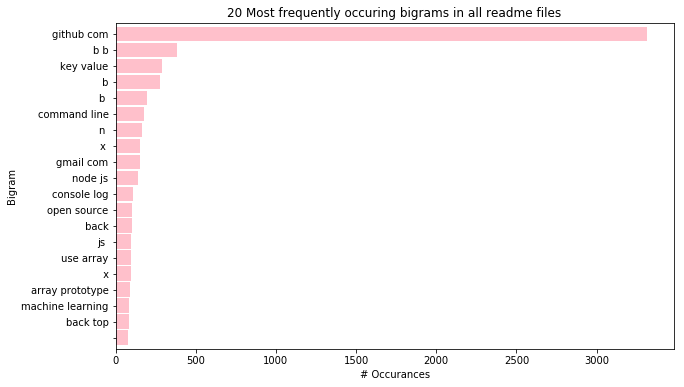

In [80]:
top_20_bigram_freq_all.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring bigrams in all readme files')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_bigram_freq_all.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

Well, that makes sense! Let's drop github com...

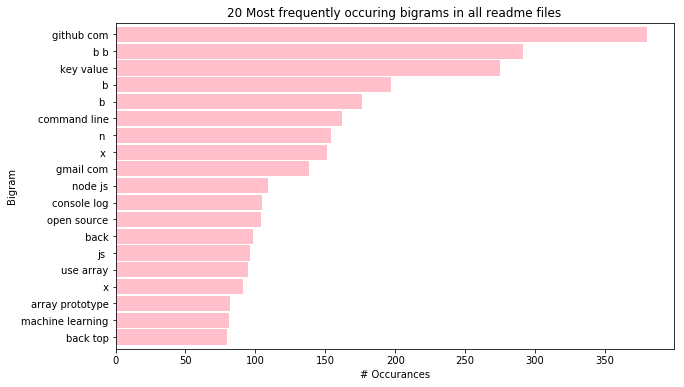

In [81]:
top_20_bigram_freq_all[1:].sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring bigrams in all readme files')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_bigram_freq_all[1:].reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

# MATT, I give up. I spent way too much time trying to figure out how to make these darm bigrams work. Sorry.

In [82]:
bigram_counts = (pd.concat([top_20_bigram_freq_all, top_20_bigram_freq_js, 
                            top_20_bigram_freq_python, top_20_bigram_freq_java, 
                            top_20_bigram_freq_cpp, top_20_bigram_freq_go, 
                            top_20_bigram_freq_scala, top_20_bigram_freq_ruby, 
                            top_20_bigram_freq_obj_c], axis=1, sort=True)
                .set_axis(['all', 'js', 
                           'python', 'java', 
                           'cplusplus', 'go', 
                           'scala', 'ruby', 
                           'obj_c'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

bigram_counts.head().append(word_counts.tail())

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,all,cplusplus,go,java,javascript,js,obj_c,python,ruby,scala
"(, )",3314,69,72,149,NaN,2018.0,82,582,11,331
"(, b)",91,0,0,0,NaN,65.0,0,0,0,18
"(, back)",154,0,0,0,NaN,154.0,0,0,0,0
"(, const)",0,0,0,0,NaN,63.0,0,0,0,0
"(, hours)",0,0,0,0,NaN,0.0,0,55,0,0
zurich,1,0,0,0,1.0,NaN,0,0,0,0
zxcvbn,1,0,0,0,1.0,NaN,0,0,0,0
zxf,1,0,0,0,0.0,NaN,0,1,0,0
zynga,1,0,0,0,0.0,NaN,0,1,0,0
zyszys,2,0,0,0,2.0,NaN,0,0,0,0


In [87]:
(bigram_counts
 .assign(bigrams_js = top_20_bigram_freq_js / top_20_bigram_freq_all,
         bigrams_python = top_20_bigram_freq_python / top_20_bigram_freq_all, 
         bigrams_java = top_20_bigram_freq_java / top_20_bigram_freq_all,
         bigrams_cpp = top_20_bigram_freq_cpp / top_20_bigram_freq_all, 
         bigrams_go = top_20_bigram_freq_go / top_20_bigram_freq_all, 
         bigrams_scala = top_20_bigram_freq_scala / top_20_bigram_freq_all,
         bigrams_ruby = top_20_bigram_freq_ruby / top_20_bigram_freq_all,
         bigrams_obj_c = top_20_bigram_freq_obj_c / top_20_bigram_freq_all)
 .sort_values(by=top_20_bigram_freq_all)
 [['js', 'python', 'java', 'cplusplus', 'go', 'scala', 'go', 'scala', 'ruby', 'obj_c']]
 .tail(20)
 .sort_values(top_20_bigram_freq_all)
 .plot.barh(stacked=True))

plt.title('Proportion of language for the 20 most common bigrams')

KeyError: (, )                   3314
(back, top)             380
(machine, learning)     291
(array, prototype)      275
(, x)                   197
(use, array)            176
(js, )                  162
(, back)                154
(open, source)          151
(console, log)          138
(node, js)              109
(gmail, com)            105
(x, )                   104
(n, )                    98
(command, line)          96
(b, )                    95
(, b)                    91
(key, value)             82
(b, b)                   81
(github, com)            80
dtype: int64

In [84]:
bigram_freq_for_all = pd.Series(top_20_all_bigrams.split()).value_counts()
js_bigram_freq = pd.Series(top_20_js_bigrams.split()).value_counts()
python_bigram_freq = pd.Series(top_20_python_bigrams.split()).value_counts()
java_bigram_freq = pd.Series(top_20_java_bigrams.split()).value_counts()
cpp_bigram_freq = pd.Series(top_20_cpp_bigrams.split()).value_counts()

NameError: name 'top_20_all_bigrams' is not defined

In [85]:
bi_counts = (pd.concat([bigram_freq_for_all, jjs_bigram_freq, python_bigram_freq, java_bigram_freq, cpp_bigram_freq], axis=1, sort=True)
                .set_axis(['all', 'javascript', 'python', 'java', 'cplusplus'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

NameError: name 'bigram_freq_for_all' is not defined

In [86]:
js_python_bi = pd.DataFrame() 
js_python_bi = pd.concat([word_counts[word_counts.cplusplus == 0].sort_values(by='java').tail(),
           word_counts[word_counts.java == 0].sort_values(by='cplusplus').tail()])
js_python_bi[['all', 'java', 'cplusplus']]

,all,java,cplusplus
elasticsearch,47,20,0
reactivex,21,21,0
schedulers,22,21,0
operator,84,27,0
flowable,34,34,0
key,300,0,25
framework,309,0,33
tensorflow,75,0,36
electron,85,0,48
swift,99,0,73
